In [15]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [16]:
import tensorflow as tf

Simple demo neural network classifier:

In [17]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

num_classes = 2

def build_classifier(num_classes, num_dimensions=1781):

    classifier = Sequential([
        Dense(1024, activation='relu', input_shape=(num_dimensions, )),
        Dense(128, activation='relu'),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    classifier.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy',])
    return classifier

In [18]:
import numpy as np

with open("test_data/SRR_lists/SRR_normal_candidate47.list") as normal_subjects_file:
    healthy_subjects = [line.strip() for line in normal_subjects_file]

with open("test_data/SRR_lists/SRR_aml_candidate50.list") as diseased_subjects_file:
    diseased_subjects = [line.strip() for line in diseased_subjects_file]

In [19]:
print(len(healthy_subjects), len(diseased_subjects))

47 50


In [20]:
def load_data(subjects_array, subdirectory="test_data/test_counts/"):
    a = []
    for person in subjects_array:
        try:
            with open(subdirectory + person + ".count") as person_file:
                vector = [line.strip().split()[-1] for line in person_file]
                a.append(np.array(vector))
        except FileNotFoundError:
            continue
    return a

X_healthy = load_data(healthy_subjects)
y_healthy = [0. for _ in range(len(X_healthy))]
X_diseased = load_data(diseased_subjects)
y_diseased = [1. for _ in range(len(X_diseased))]

In [21]:
print(len(X_healthy), len(X_diseased))
print(len(y_healthy), len(y_diseased))

30 47
30 47


In [22]:
num_test_per_class = 2

X = np.array(X_healthy[:-num_test_per_class] + X_diseased[:-num_test_per_class])
y = np.array(y_healthy[:-num_test_per_class] + y_diseased[:-num_test_per_class])

X_test = np.array(X_healthy[-num_test_per_class:] + X_diseased[-num_test_per_class:])
y_test = np.array(y_healthy[-num_test_per_class:] + y_diseased[-num_test_per_class:])

In [23]:
num_people = len(X)

One-Hot Encode Output Labels:

In [24]:
from tensorflow.python.keras.utils import to_categorical

y1hot = to_categorical(y, num_classes=num_classes)

## K-Fold Cross Validation
Since we don't have many people represented in our data, we'll do leave-one-out cross validation:

In [25]:
from sklearn.model_selection import KFold
from tensorflow.python.keras.callbacks import ModelCheckpoint

kf = KFold(n_splits=num_people)
fold_number = 1
cvscores = []
for train_index, val_index in kf.split(X):
    print("Fold " + str(fold_number))
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y1hot[train_index], y1hot[val_index]
    classifier = build_classifier(num_classes=num_classes)
    filename = "fold{}.weights.hdf5".format(fold_number)
    model_checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
    classifier.fit(X_train, y_train, batch_size=num_people, epochs=8, validation_data=(X_val, y_val), verbose=2, callbacks=[model_checkpointer])
    classifier.load_weights(filename)
    scores = classifier.evaluate(X_val, y_val, verbose=0)
    print(classifier.metrics_names)
    print(scores)
    cvscores.append(scores)
    del classifier
    fold_number += 1

Fold 1
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 2.1402 - acc: 0.4306 - val_loss: 2.5552 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.55519, saving model to fold1.weights.hdf5
Epoch 2/8
 - 0s - loss: 3.2359 - acc: 0.6250 - val_loss: 2.0557 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 2.55519 to 2.05572, saving model to fold1.weights.hdf5
Epoch 3/8
 - 0s - loss: 2.9486 - acc: 0.6250 - val_loss: 1.3181 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 2.05572 to 1.31807, saving model to fold1.weights.hdf5
Epoch 4/8
 - 0s - loss: 2.7071 - acc: 0.6250 - val_loss: 0.9248 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 1.31807 to 0.92484, saving model to fold1.weights.hdf5
Epoch 5/8
 - 0s - loss: 2.5152 - acc: 0.6250 - val_loss: 0.7045 - val_acc: 0.0000e+00

Epoch 00005: val_loss improved from 0.92484 to 0.70448, saving model to fold1.weights.hdf5
Epoch 6/8
 - 0s - loss: 2.2832 - acc: 0.7917 - val_loss: 0.4463 

In [28]:
accuracies = np.array(cvscores)[:, 1]

In [30]:
print("%.2f (+/- %.2f)" % (np.mean(accuracies), np.std(accuracies)))

0.99 (+/- 0.12)


##  Cross-validated accuracy is higher than guessing the most popular class (diseased -- 47 / (30 + 47) == 61%)

## Predict phenotype on test data using ensemble average of K models

In [31]:
y_test1hot = to_categorical(y_test, num_classes=num_classes)

In [32]:
predictions = []
for fold in range(num_people):
    model = build_classifier(num_classes=num_classes)
    model.load_weights("fold{}.weights.hdf5".format(fold + 1))
    predictions.append(model.predict(np.array(X_test)))

In [33]:
avg_predictions = np.mean(predictions, axis=0)

In [34]:
y_pred = np.argmax(avg_predictions, axis=1)

Confusion matrix, without normalization
[[1 1]
 [0 2]]


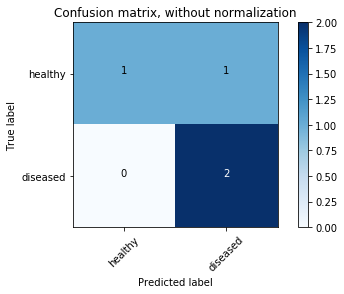

In [36]:
%matplotlib inline


# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["healthy", "diseased"],
                      title='Confusion matrix, without normalization')